# Vehicle Detection and Tracking

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import glob 
import cv2
import numpy as np
import skimage
import matplotlib.image as mpimg
from skimage import data, color, exposure
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Lambda
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import matplotlib.pylab as plt

%matplotlib inline
%load_ext autoreload
%matplotlib inline

Using TensorFlow backend.


In [2]:

cars = glob.glob("./data/vehicles/*/*.png")
non_cars = glob.glob("./data/non-vehicles/*/*.png")

# make ground truth
Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))-1])
# read X
X = []
for name in cars:    
    X.append(skimage.io.imread(name))
for name in non_cars:    
    X.append(skimage.io.imread(name))
X = np.array(X)

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
input_shape =  (3,64,64)

X_train shape: (15984, 64, 64, 3)
15984 train samples
1776 test samples


In [53]:
#load testing picture

TEST_IMG_RBG = mpimg.imread(cars[4])
TEST_IMG_G = cv2.cvtColor(TEST_IMG_RBG, cv2.COLOR_RGB2GRAY)

TEST_FULL_IMG = mpimg.imread("./test_images/test1.jpg")

## 1. Histogram of Oriented Gradients (HOG)
#### 1.1.1 Explain how (and identify where in your code) you extracted HOG features from the training images. 

In [6]:
def process_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

#### 1.1.2 Explain how you settled on your final choice of HOG parameters.

In [7]:
orient = 9
pix_per_cell = 4
cell_per_block = 2

In [9]:
# Call our function with vis=True to see an image output
features, hog_image = process_hog_features(TEST_IMG_G, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

/home/holman/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


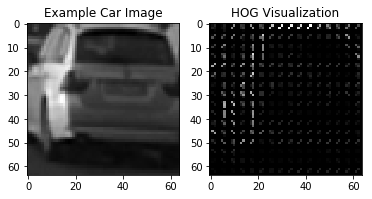

In [14]:
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(TEST_IMG_G, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [15]:
hog_image.shape

(64, 64)

#### 1.2 Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

In [22]:
# define conv layers
def conv_layers(input_shape, weights_file=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv1',input_shape=input_shape, border_mode="same"))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv2',border_mode="same"))
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.25))
    model.add(Convolution2D(128,8,8,activation="relu",name="dense1")) 
    model.add(Dropout(0.5))
    model.add(Convolution2D(1,1,1,name="dense2", activation="tanh")) 
    if weights_file:
        model.load_weights(weights_file)        
    return model

In [ ]:
# train model
model = conv_layers((64,64,3))
model.add(Flatten())
model.compile(loss='mse',optimizer='adadelta',metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=128, nb_epoch=20, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
model.save_weights("weights.h5")

Train on 15984 samples, validate on 1776 samples
Epoch 1/20
15984/15984 [==============================] - 44s - loss: 0.5358 - acc: 0.4793 - val_loss: 0.2920 - val_acc: 0.7455

In [56]:
heatMapModel = conv_layers(input_shape=(None,None,3), weights_file="weights.h5")

def localize(img_rgb, videoMode=False):    
    heatmap = heatMapModel.predict(img_rgb.reshape(1,img_rgb.shape[0],img_rgb.shape[1],img_rgb.shape[2]))
    
    if not videoMode:
        plt.imshow(heatmap[0,:,:,0])
        plt.title("Heatmap")
        plt.show()
        plt.imshow(heatmap[0,:,:,0]>0.99, cmap="gray")
        plt.title("Car Area")
        plt.show()

    xx, yy = np.meshgrid(np.arange(heatmap.shape[2]),np.arange(heatmap.shape[1]))
    x = (xx[heatmap[0,:,:,0]>0.99])
    y = (yy[heatmap[0,:,:,0]>0.99])
    
    for i,j in zip(x,y):
        cv2.rectangle(img_rgb, (i*8,j*8), (i*8+64,j*8+64), (0,0,255), 5)
    return img_rgb



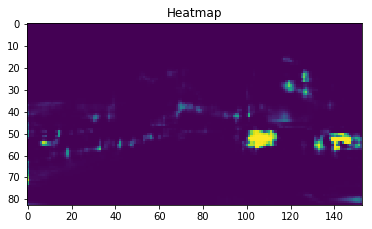

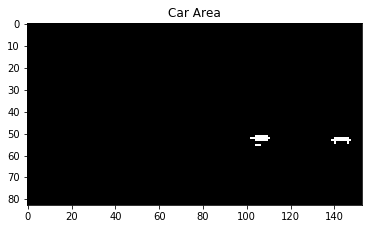

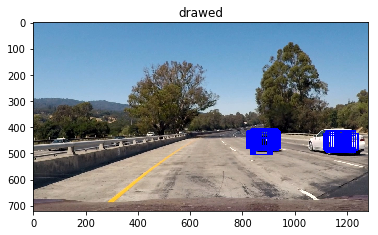

In [58]:
cp = np.copy(TEST_FULL_IMG)
annotated = localize(cp)

plt.title("drawed")    
plt.imshow(annotated, cmap=plt.cm.Greys)
plt.show()

## 2. Sliding Window Search
#### 2.1.1 Describe how (and identify where in your code) you implemented a sliding window search. 

####  2.1.2 How did you decide what scales to search and how much to overlap windows?

#### 2.2.1 Show some examples of test images to demonstrate how your pipeline is working. 

#### 2.2.1 How did you optimize the performance of your classifier?

## 3. Video Implementation
#### 3.1 Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

#### 3.2 Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

## 3. Discussion
#### 3.1 Briefly discuss any problems / issues you faced in your implementation of this project. 

#### 3.2 Where will your pipeline likely fail?

#### 3.3 What could you do to make it more robust?